In [114]:
#@title Imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, create_optimizer, TFGPT2ForSequenceClassification, TFGPT2Model
from datasets import Dataset, DatasetDict

In [115]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [116]:
model_name = 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
len(tokenizer)

50257

In [117]:
model_name = 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]', 'cls_token':'[CLS]'})
tokenizer.padding_side = 'left'
tokenizer.truncation_side = 'left'
len(tokenizer)

50259

# Preprocessing

## Data cleaning

In [118]:
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}
def transform_appos(headline):
    arr = []
    for row in headline.values:
        for word in row:
            if word in appos.keys():
                row = row.replace(word, appos[word])
    return headline

def to_lowercase(headline):
    headline = headline.apply(lambda x: x.lower())
    return headline

def remove_whitespaces(headline):
    headline = headline.str.strip()
    return headline

def replace_quote(headline):
    headline = headline.str.replace("’", "'")
    return headline

def preprocess(headlines: pd.Series):
    headlines = to_lowercase(headlines)
    headlines = replace_quote(headlines)
    headlines = transform_appos(headlines)
    return headlines

In [119]:
# apply data cleaning to the whole dataset
df['headline'] = preprocess(df['headline'])

## Preprocessing for huggingface

In [120]:
df['headline'] = df['headline'].apply(lambda x: x + '[CLS]')

In [121]:
def create_datasets_from_dataframe(df: pd.DataFrame):
    # split data into train and test set into 60:20:20
    train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=0)
    val_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=0)

    # create dataset objects 
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # create dataset dict with dataset objects
    datasets = DatasetDict()
    datasets['train'] = train_dataset
    datasets['val'] = val_dataset
    datasets['test'] = test_dataset
    return datasets

datasets = create_datasets_from_dataframe(df)

In [122]:
# first sentence
print(datasets['train'][0])
print(tokenizer(datasets['train'][0]['headline']))

{'headline': "bernice king says trump's racist comments are 'troubling to our humanity'[CLS]", 'is_sarcastic': 0, '__index_level_0__': 17847}
{'input_ids': [33900, 501, 5822, 1139, 19997, 338, 9811, 3651, 389, 705, 83, 472, 11108, 284, 674, 9265, 6, 50258], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [123]:
# tokenize and dynamic padding with collator
def tokenize_function(item):
    return tokenizer(item['headline'],
                     padding=True,
                     truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True) 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [124]:
# just peek at how the data looks like
print(tokenizer.decode((tokenized_datasets['train'][1]['input_ids'])))
print(tokenized_datasets['train'][1]['input_ids'])
print(len(tokenized_datasets['train'][1]['input_ids']))

[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]world's most innovative companies[CLS]
[50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 6894, 338, 749, 13097, 2706, 50258]
41


In [125]:
def convert_dataset_to_tf_dataset(dataset: Dataset):
    tf_dataset = dataset.to_tf_dataset(
        columns=[ "input_ids"],
        label_cols=["is_sarcastic"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=64,
    )
    return tf_dataset

tf_train_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['train'])
tf_val_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['val'])
tf_test_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['test'])

# Create and train model

In [126]:
num_of_epochs = 5

# callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# no need to save best weights, huggingface is already saving the best weights when save_pretrained() is called
save_best_weights = ModelCheckpoint('checkpoints/gpt2', 
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=True)

In [127]:
def model_builder():
    inputs = [
        Input(shape=(None,), dtype=tf.int32, name='input_ids')
    ]
    
    gpt2 = TFGPT2Model.from_pretrained(model_name)
    gpt2.resize_token_embeddings(len(tokenizer))
    gpt2.pad_token_id = '[PAD]'
    gpt2.cls_token_id = '[CLS]'
    cls = gpt2(inputs).last_hidden_state[:, -1, :]
    outputs = Dense(units=1, activation='sigmoid', name='binary_classification')(cls)


    # create Model
    model = Model(inputs, outputs)

    optimizer, _ = create_optimizer(init_lr=5e-5,
                                    num_train_steps= len(tf_train_dataset) * num_of_epochs,
                                    num_warmup_steps=400,
                                    min_lr_ratio=0)

    model.compile(optimizer, BinaryCrossentropy(), ['acc'])
    return model

In [128]:
model = model_builder()
history = model.fit(tf_train_dataset,
          validation_data=tf_val_dataset,
          epochs=num_of_epochs,
          callbacks=[stop_early, save_best_weights])

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


251/251 [==============================] - 174s 566ms/step - loss: 0.5850 - acc: 0.6714 - val_loss: 0.4390 - val_acc: 0.8179
Epoch 2/5
251/251 [==============================] - 140s 557ms/step - loss: 0.3148 - acc: 0.8621 - val_loss: 0.2540 - val_acc: 0.8955
Epoch 3/5
251/251 [==============================] - 139s 555ms/step - loss: 0.2124 - acc: 0.9106 - val_loss: 0.2474 - val_acc: 0.9042
Epoch 4/5
251/251 [==============================] - 136s 543ms/step - loss: 0.1531 - acc: 0.9415 - val_loss: 0.2619 - val_acc: 0.9098
Epoch 5/5
251/251 [==============================] - 137s 546ms/step - loss: 0.1058 - acc: 0.9589 - val_loss: 0.2721 - val_acc: 0.9086


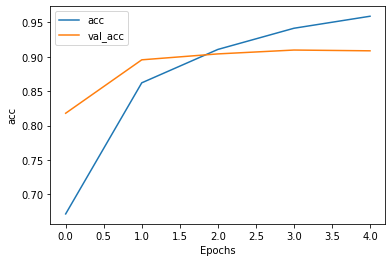

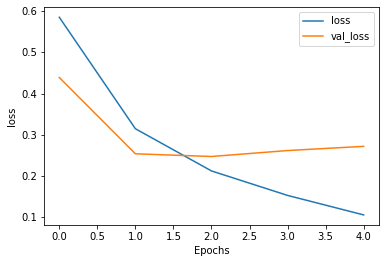

In [129]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

# Evaluate the model

In [132]:
saved_model_tf = model_builder()
saved_model_tf.load_weights('checkpoints/gpt2')
loss, acc = saved_model_tf.evaluate(tf_test_dataset)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


84/84 [==============================] - 25s 190ms/step - loss: 0.2523 - acc: 0.9028


In [133]:
predictions = saved_model_tf.predict(tf_test_dataset)
y_pred = (predictions > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3014
           1       0.90      0.88      0.89      2328

    accuracy                           0.90      5342
   macro avg       0.90      0.90      0.90      5342
weighted avg       0.90      0.90      0.90      5342

